In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from PIL import Image
import cv2
import os
import timm


/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c108ListType3getERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEENS_4Type24SingletonOrSharedTypePtrIS9_EE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))
from src.models.model_factory import get_model

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c108ListType3getERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEENS_4Type24SingletonOrSharedTypePtrIS9_EE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
class ViTAttentionVisualizer:
    def __init__(self, model, device="cpu"):
        self.device = device
        self.model = model.to(device)
        self.model.eval()

        self.attn_weights = []
        self.hook = self.model.blocks[-1].attn.register_forward_hook(self._hook_fn)

        self.transform = T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ])

    def _hook_fn(self, module, input, output):
        qkv = module.qkv(input[0])
        B, N, _ = qkv.shape
        qkv = qkv.reshape(B, N, 3, module.num_heads, module.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = attn.softmax(dim=-1)
        self.attn_weights.append(attn.detach())

    def visualize(self, image, save_path=None, show=True):
        self.attn_weights = []

        # Aceita path ou PIL.Image
        if isinstance(image, str):
            image = Image.open(image).convert("RGB")
        elif not isinstance(image, Image.Image):
            raise TypeError("`image` must be a path or a PIL.Image")

        original_size = image.size
        img_tensor = self.transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            _ = self.model(img_tensor)

        if not self.attn_weights:
            print("❌ Nenhum mapa de atenção capturado.")
            return

        attn = self.attn_weights[0]
        attn = attn.mean(1)
        cls_attn = attn[0, 0, 1:]

        num_patches = cls_attn.shape[0]
        grid_size = int(np.sqrt(num_patches))
        mask = cls_attn.reshape(grid_size, grid_size).cpu().numpy()
        mask = cv2.resize(mask, original_size)
        mask = (mask - mask.min()) / (mask.max() - mask.min())

        overlay = np.array(image).astype(np.uint8)
        cmap = plt.get_cmap("jet")
        heatmap = (cmap(mask)[:, :, :3] * 255).astype(np.uint8)
        blended = cv2.addWeighted(overlay, 0.5, heatmap, 0.5, 0)

        if show:
            plt.figure(figsize=(6, 6))
            plt.imshow(blended)
            plt.title("Attention Map - CLS token")
            plt.axis("off")
            plt.show()

        if save_path:
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            Image.fromarray(blended).save(save_path)
            print(f"✅ Saved attention map to {save_path}")

    def remove_hook(self):
        self.hook.remove()

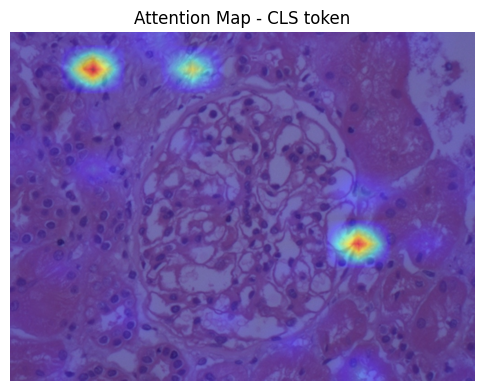

✅ Saved attention map to outputs/map.png


In [8]:
image_path = "../datasets/final/glomerulo/train/Normal/Terumo_Normal_HE/2414115.jpeg"
model = timm.create_model("vit_base_patch16_224", pretrained=True)
# 🔍 Visualizar atenção
visualizer = ViTAttentionVisualizer(model, device="cpu")


visualizer.visualize(image_path, save_path="outputs/map.png", show=True)

visualizer.remove_hook()